# Predicting Industrial Machine Downtime
![](img/industrial-machine.jpg)

*A [DataCamp](https://datacamp.com) challenge* &nbsp;&nbsp;&nbsp;&nbsp;{octicon}`calendar` Mar, 2025  

{bdg-secondary-line}`Classification`

## The project
A manufacturer of high-precision metal components used in aerospace, automotives, and medical device applications operates three different machines on its shop floor that produce different sized components, so minimizing the downtime of these machines is vital for meeting production deadlines.

The aim is to use a data-driven approach to predicting machine downtime, so proactive maintenance can be planned rather than being reactive to machine failure. To support this, the company has been collecting operational data for over a year and whether each machine was down at those times.

Develop a predictive model that could be combined with real-time operational data to detect likely machine failure.

## The data

The company has stored the machine operating data in a single table. Each row in the table represents the operational data for a single machine on a given day:

- `"Date"` - the date the reading was taken on.
- `"Machine_ID"` - the unique identifier of the machine being read.
- `"Assembly_Line_No"` - the unique identifier of the assembly line the machine is located on.
- `"Hydraulic_Pressure(bar)"`, `"Coolant_Pressure(bar)"`, and `"Air_System_Pressure(bar)"` - pressure measurements at different points in the machine.
- `"Coolant_Temperature"`, `"Hydraulic_Oil_Temperature"`, and `"Spindle_Bearing_Temperature"` - temperature measurements (in Celsius) at different points in the machine.
- `"Spindle_Vibration"`, `"Tool_Vibration"`, and `"Spindle_Speed(RPM)"` - vibration (measured in micrometers) and rotational speed measurements for the spindle and tool.
- `"Voltage(volts)"` - the voltage supplied to the machine.
- `"Torque(Nm)"` - the torque being generated by the machine.
- `"Cutting(KN)"` - the cutting force of the tool.
- `"Downtime"` - an indicator of whether the machine was down or not on the given day.

In [1]:
# Import packages
import calendar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Read the data
downtime = pd.read_csv(
    "data/machine_downtime.csv",
    parse_dates=["Date"],
    date_format="%d-%m-%Y",
    index_col="Date",
)
downtime

,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
Date,,,,,,,,,,,,,,,
2021-12-31,Makino-L1-Unit1-2013,Shopfloor-L1,71.040000,6.933725,6.284965,25.6,46.0,33.4,1.291,26.492,25892.0,335.0,24.055326,3.58,Machine_Failure
2021-12-31,Makino-L1-Unit1-2013,Shopfloor-L1,125.330000,4.936892,6.196733,35.3,47.4,34.6,1.382,25.274,19856.0,368.0,14.202890,2.68,Machine_Failure
2021-12-31,Makino-L3-Unit1-2015,Shopfloor-L3,71.120000,6.839413,6.655448,13.1,40.7,33.0,1.319,30.608,19851.0,325.0,24.049267,3.55,Machine_Failure
2022-05-31,Makino-L2-Unit1-2015,Shopfloor-L2,139.340000,4.574382,6.560394,24.4,44.2,40.6,0.618,30.791,18461.0,360.0,25.860029,3.55,Machine_Failure
2022-03-31,Makino-L1-Unit1-2013,Shopfloor-L1,60.510000,6.893182,6.141238,4.1,47.3,31.4,0.983,25.516,26526.0,354.0,25.515874,3.55,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,Makino-L1-Unit1-2013,Shopfloor-L1,112.715506,5.220885,6.196610,22.3,48.8,37.2,0.910,20.282,20974.0,282.0,22.761610,2.72,No_Machine_Failure
2022-02-01,Makino-L1-Unit1-2013,Shopfloor-L1,103.086653,5.211886,7.074653,11.9,48.3,31.5,1.106,34.708,20951.0,319.0,22.786597,2.94,No_Machine_Failure
2022-02-01,Makino-L2-Unit1-2015,Shopfloor-L2,118.643165,5.212991,6.530049,4.5,49.9,36.2,0.288,16.828,20958.0,335.0,22.778987,NaN,No_Machine_Failure


## Data validation
### Check data quality

In [2]:
# Get dataframe info
downtime.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2021-12-31 to 2022-02-01
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Machine_ID                   2500 non-null   object 
 1   Assembly_Line_No             2500 non-null   object 
 2   Hydraulic_Pressure(bar)      2490 non-null   float64
 3   Coolant_Pressure(bar)        2481 non-null   float64
 4   Air_System_Pressure(bar)     2483 non-null   float64
 5   Coolant_Temperature          2488 non-null   float64
 6   Hydraulic_Oil_Temperature    2484 non-null   float64
 7   Spindle_Bearing_Temperature  2493 non-null   float64
 8   Spindle_Vibration            2489 non-null   float64
 9   Tool_Vibration               2489 non-null   float64
 10  Spindle_Speed(RPM)           2494 non-null   float64
 11  Voltage(volts)               2494 non-null   float64
 12  Torque(Nm)                   2479 non-null   float64
 13  

I will drop records with missing values.

In [3]:
# Drop records with missing values
downtime.dropna(inplace=True)

Check for duplicated.

In [4]:
# Check duplicated rows
downtime.duplicated().sum()

0

There are no duplicated records.

### Check value ranges
#### Categorical columns
Based on the dataframe overview, it appears that `Machine_ID` and `Assembly_Line_No` refer to the same information. If that's the case, one of these columns may be redundant.  
Let's check this out!

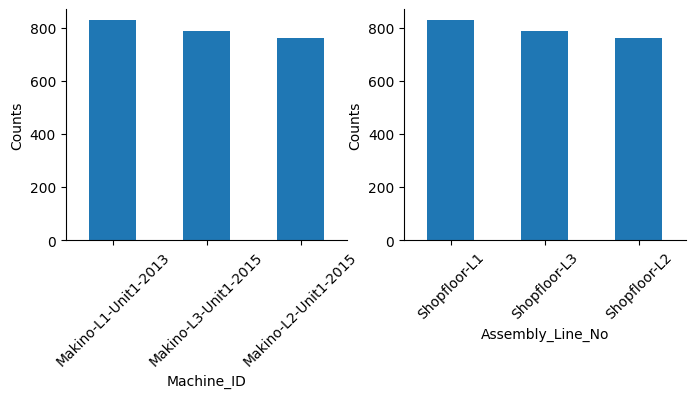

In [5]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
downtime["Machine_ID"].value_counts().plot(ax=ax[0], kind="bar")
downtime["Assembly_Line_No"].value_counts().plot(ax=ax[1], kind="bar")
for i in range(2):
    ax[i].set_ylabel("Counts")
    ax[i].tick_params(axis="x", labelsize=10, rotation=45)
sns.despine()
plt.show()

It looks so. Let's confirm it labeling them with a number and calculating the relative correlation coefficient.

In [6]:
# Relate identifiers with numbers to encode machines and lines
machine_encoding = {"Makino-L1-Unit1-2013": 1, "Makino-L2-Unit1-2015": 2, "Makino-L3-Unit1-2015": 3}
line_encoding = {"Shopfloor-L1": 1, "Shopfloor-L2": 2, "Shopfloor-L3": 3}

# Replace machine ID name by number
downtime["Machine_ID"] = downtime["Machine_ID"].apply(lambda x: machine_encoding[x])

# Replace line name by number
downtime["Assembly_Line_No"] = downtime["Assembly_Line_No"].apply(lambda x: line_encoding[x])

# Get correlation between these columns
print(f"Correlation -> {downtime["Machine_ID"].corr(downtime["Assembly_Line_No"])}")

Correlation -> 0.9999999999999999


They are indeed identical, so we can drop one of the columns, `Assembly_Line_No` for instance.

In [7]:
# Drop column
downtime.drop("Assembly_Line_No", axis=1, inplace=True)

Let's check how balanced the target variable is:

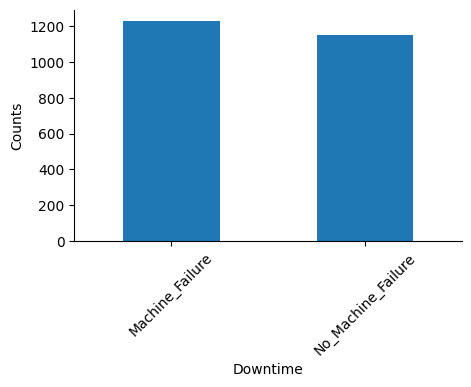

In [8]:
# Plot
fig, ax = plt.subplots(figsize=(5, 3))
downtime["Downtime"].value_counts().plot(ax=ax, kind="bar")
ax.tick_params(axis="x", labelsize=10, rotation=45)
ax.set_ylabel("Counts")
sns.despine()
plt.show()

Quite balanced. I will replace "Machine_Failure" by numeric value "1" and "No_Machine_Failure" by "0".

In [9]:
# Replace target by numerical values
downtime["Downtime"] = downtime["Downtime"].apply(
    lambda x: 1 if x == "Machine_Failure" else 0
)

# Get dataframe info
downtime.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2381 entries, 2021-12-31 to 2022-02-01
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Machine_ID                   2381 non-null   int64  
 1   Hydraulic_Pressure(bar)      2381 non-null   float64
 2   Coolant_Pressure(bar)        2381 non-null   float64
 3   Air_System_Pressure(bar)     2381 non-null   float64
 4   Coolant_Temperature          2381 non-null   float64
 5   Hydraulic_Oil_Temperature    2381 non-null   float64
 6   Spindle_Bearing_Temperature  2381 non-null   float64
 7   Spindle_Vibration            2381 non-null   float64
 8   Tool_Vibration               2381 non-null   float64
 9   Spindle_Speed(RPM)           2381 non-null   float64
 10  Voltage(volts)               2381 non-null   float64
 11  Torque(Nm)                   2381 non-null   float64
 12  Cutting(kN)                  2381 non-null   float64
 13  

#### Numerical columns
Apart from the target and the Machine_ID, features are all numerical float data type. I will plot their value ranges to get a sense of their scope.

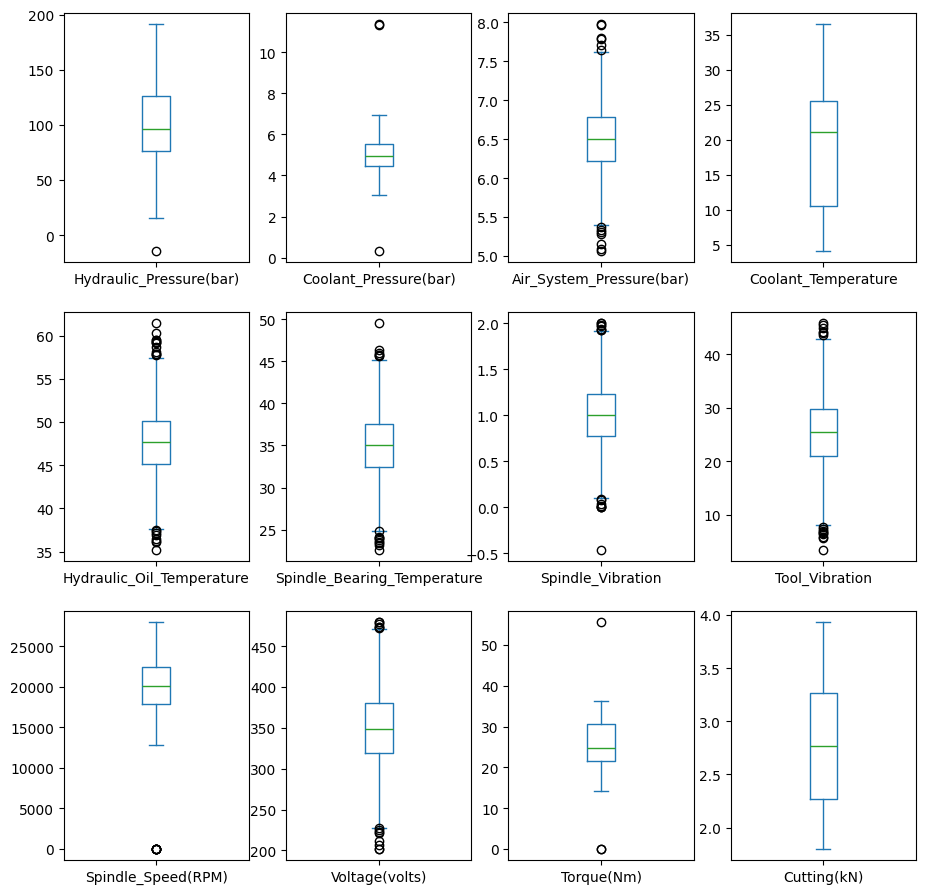

In [10]:
# Define feature list
features = downtime.select_dtypes(include="float64").columns

# Plot
rows = 3
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(11, 11))
i, j = 0, 0
for n, feature in enumerate(features):
    downtime[feature].plot(ax=ax[i, j], kind="box")
    j += 1  # Next col
    if (n + 1) % cols == 0:  # Next row, reset col
        i += 1
        j = 0

plt.show()

#### Sort dates
I will sort the dataframe by dates (the index) and print first and last recorded date.

In [11]:
# Sort dataframe by date, which is the index
downtime.sort_index(inplace=True)

# Print
print(f"Data readings starting at: {downtime.index[0].strftime('%Y-%m-%d')}")
print(f"Data readings ending at: {downtime.index[-1].strftime('%Y-%m-%d')}")

Data readings starting at: 2021-11-24
Data readings ending at: 2022-06-19


## Exploratory Data analysis

### Downtime ratios

#### By machine
Which machine has the highest readings of machine downtime?

In [12]:
# Compare downtime metrics between machines
downtime.groupby("Machine_ID")["Downtime"].agg(["count", "sum", "mean"]).rename(
    columns={"sum": "downtimes", "mean": "downtime_ratio"}
)

,count,downtimes,downtime_ratio
Machine_ID,,,
1,830,440,0.530120
2,763,382,0.500655
3,788,409,0.519036


Machine number 1 has the highest machine downtime ratio (it is also counted for more times).

#### Monthly

In [13]:
# Group by month
downtime.groupby(downtime.index.month)["Downtime"].agg(["count", "sum", "mean"])

,count,sum,mean
Date,,,
1,170,84,0.494118
2,554,282,0.509025
3,1005,526,0.523383
4,512,274,0.535156
5,110,48,0.436364
6,7,3,0.428571
11,1,1,1.000000
12,22,13,0.590909


Months 11 (November) and 6 (June) have scarce records, and 12 (December) has little more, so their values should not be representative.

#### By machine and monthly

In [14]:
# Group by month and by machine
downtime.pivot_table(
    index=downtime.index.month,
    columns="Machine_ID",
    values="Downtime",
    aggfunc=["count", "sum", "mean"],
)

count                  sum                    mean            \
Machine_ID      1      2      3      1      2      3         1         2   
Date                                                                       
1            61.0   54.0   55.0   33.0   22.0   29.0  0.540984  0.407407   
2           182.0  165.0  207.0   85.0   85.0  112.0  0.467033  0.515152   
3           349.0  323.0  333.0  191.0  166.0  169.0  0.547278  0.513932   
4           188.0  171.0  153.0  107.0   85.0   82.0  0.569149  0.497076   
5            39.0   40.0   31.0   16.0   18.0   14.0  0.410256  0.450000   
6             1.0    4.0    2.0    0.0    3.0    0.0  0.000000  0.750000   
11            NaN    NaN    1.0    NaN    NaN    1.0       NaN       NaN   
12           10.0    6.0    6.0    8.0    3.0    2.0  0.800000  0.500000   

                      
Machine_ID         3  
Date                  
1           0.527273  
2           0.541063  
3           0.507508  
4           0.535948  
5           0.451613  
6           0.000000  
11          1.000000  
12          0.333333

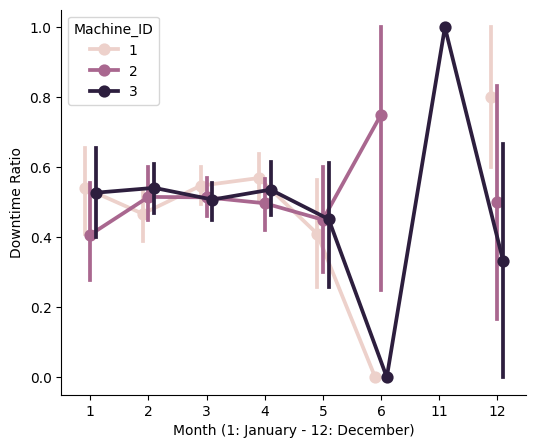

In [15]:
# Plot by month
fig, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(
    ax=ax,
    x=downtime.index.month,
    y="Downtime",
    data=downtime,
    hue="Machine_ID",
    dodge=0.2,
)
ax.set_xlabel("Month (1: January - 12: December)")
ax.set_ylabel("Downtime Ratio")
sns.despine()
plt.show()

As mentioned before, values in months 6, 11 and 12 are not representative.

#### By machine and day of the week

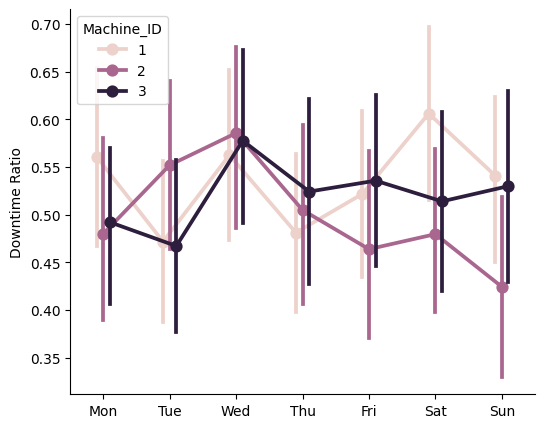

In [16]:
# Plot by day of the week
fig, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(
    ax=ax,
    x=downtime.index.dayofweek,
    y="Downtime",
    data=downtime,
    hue="Machine_ID",
    dodge=0.2,
)
ax.set_xlabel("")
ax.set_ylabel("Downtime Ratio")
ax.set_xticks(range(7), labels=list(calendar.day_abbr))
sns.despine()
plt.show()

Confidence intervals overlap, so there is no significative difference between days of the week.

I've concluded that the time series in the index of this dataframe does not appear to have any meaningful predictive power regarding machine downtime.

### Correlations of features
Let's calculate correlation coeficients between the features.

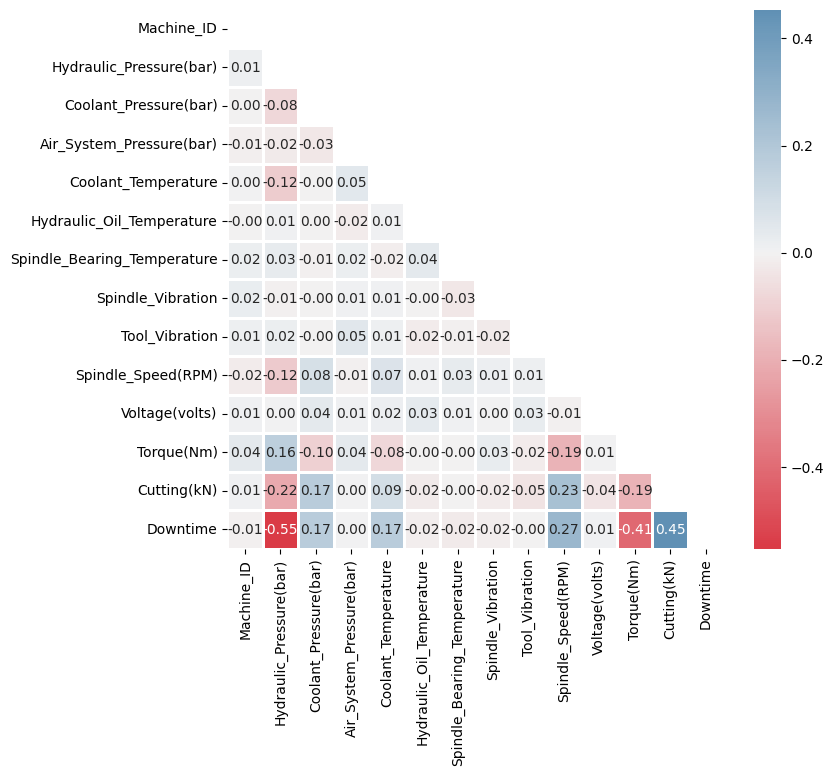

In [17]:
# Get pearson correlation matrix
corr = downtime.corr()

# Create a mask to only show half of the matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a diverging color palette between two HUSL colors.
cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(8, 7))

sns.heatmap(
    corr, ax=ax, mask=mask, center=0, cmap=cmap, linewidths=1, annot=True, fmt=".2f"
)

plt.show()

According ot their relatively high correlation, the following features seem to be mostly connected to machine downtime:
- Hydraulic Pressure (negatively)
- Torque being generated by the machine (negatively)
- Cutting force of the tool (positively)

Let's plot it!

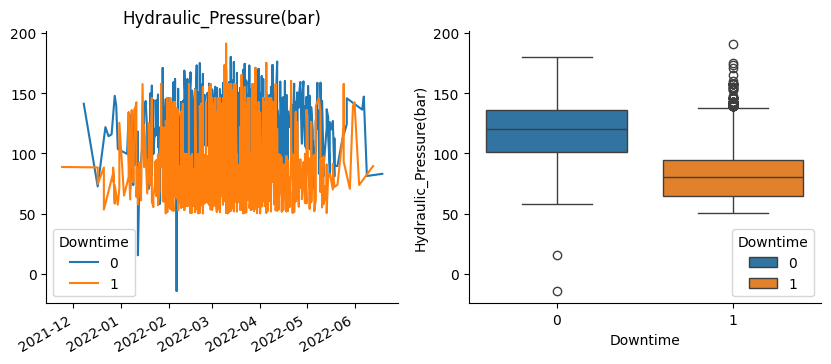

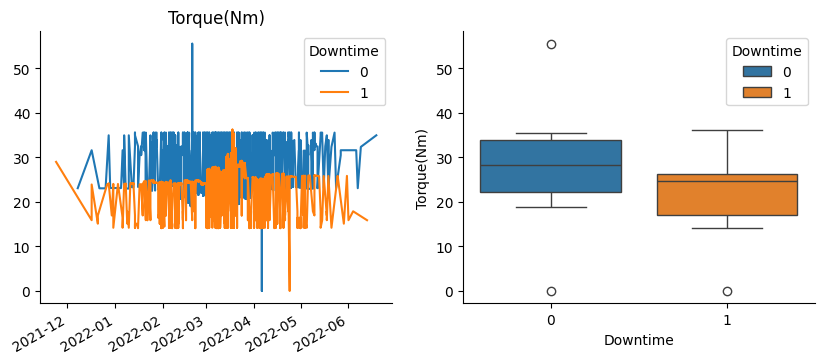

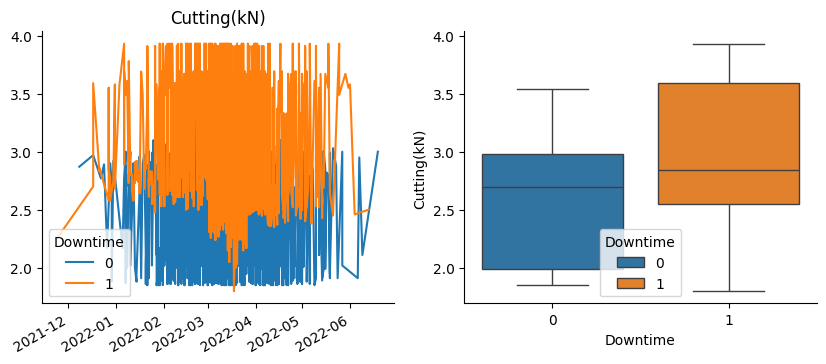

In [18]:
# Define those correlated column names in a list
corr_columns = ["Hydraulic_Pressure(bar)", "Torque(Nm)", "Cutting(kN)"]

# Subset dataframe to rows with downtime = 1 and rows with downtime = 0
downtime_yes = downtime.loc[downtime["Downtime"] == 1, :]
downtime_no = downtime.loc[downtime["Downtime"] == 0, :]

# Plot the value of the feature in each downtime case
for column in corr_columns:
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    downtime_no[column].plot(ax=ax[0], label="0")
    downtime_yes[column].plot(ax=ax[0], label="1")
    sns.boxplot(ax=ax[1], x="Downtime", y=column, data=downtime, hue="Downtime")
    ax[0].set_title(column)
    ax[0].set_xlabel("")
    ax[0].legend(title="Downtime")
    sns.despine()
    plt.show()

Indeed, in these graphs we can see those correlations and their sign.

## Modelling a classifier
### Logistic Regression
I will use a Logistic Regression model for a start.

In [19]:
# Define function for classification
def lr_classifier(X, y):

    # Split dataset into training and test set, and stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Scale
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    # Instantiate model
    model = LogisticRegression()

    # Fit model to the training set
    model.fit(X_train_scaled, y_train)

    # Predict test set values
    y_pred = model.predict(X_test_scaled)

    # Print results
    print(f"{accuracy_score(y_test, y_pred):.2f} <- Test-set accuracy ")
    print(
        f"{accuracy_score(y_train, model.predict(X_train_scaled)):.2f} <- Train-set accuracy "
    )
    print(classification_report(y_test, y_pred))

    return model


# Define features and target
y = downtime["Downtime"]
X = downtime.drop("Downtime", axis=1)

# Classify
model = lr_classifier(X, y)

0.85 <- Test-set accuracy 
0.86 <- Train-set accuracy 
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       345
           1       0.86      0.84      0.85       370

    accuracy                           0.85       715
   macro avg       0.85      0.85      0.85       715
weighted avg       0.85      0.85      0.85       715



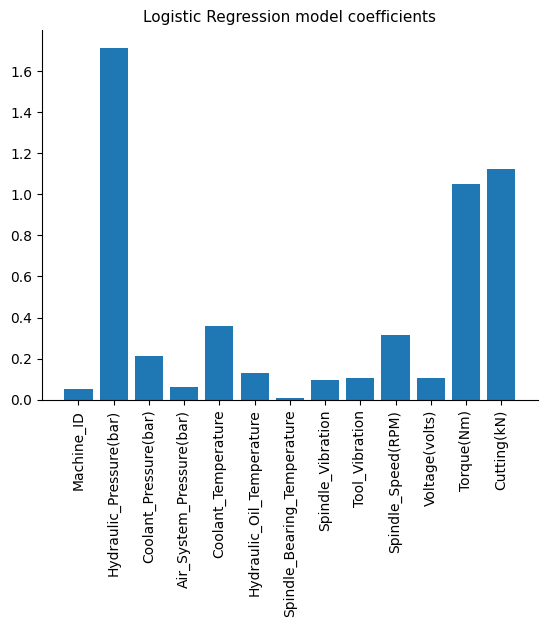

In [20]:
# Plot coefficients
plt.bar(X.columns, np.abs(model.coef_[0]))
plt.title("Logistic Regression model coefficients", fontsize=11)
plt.xticks(rotation=90)
sns.despine()
plt.show()

As expected, model coefficients show that the previous 3 most correlated features have more importance in the model.

#### Modeling machines separately
Let's see results if we consider machines 1, 2 and 3 separately.

In [21]:
# Subset dataset for each machine
machine_1 = downtime.loc[downtime["Machine_ID"] == 1, :]
machine_2 = downtime.loc[downtime["Machine_ID"] == 2, :]
machine_3 = downtime.loc[downtime["Machine_ID"] == 3, :]

# Create list of those filtered datasets
machines = [machine_1, machine_2, machine_3]

# Create classifiers separately for each machine
for i, machine in enumerate(machines):
    # Define features and target
    y = machine["Downtime"]
    X = machine.drop("Downtime", axis=1)

    # Classify
    print(f"\nMachine {i + 1}:")
    model = lr_classifier(X, y)


Machine 1:
0.87 <- Test-set accuracy 
0.87 <- Train-set accuracy 
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       117
           1       0.86      0.90      0.88       132

    accuracy                           0.87       249
   macro avg       0.87      0.87      0.87       249
weighted avg       0.87      0.87      0.87       249


Machine 2:
0.85 <- Test-set accuracy 
0.84 <- Train-set accuracy 
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       114
           1       0.85      0.86      0.85       115

    accuracy                           0.85       229
   macro avg       0.85      0.85      0.85       229
weighted avg       0.85      0.85      0.85       229


Machine 3:
0.85 <- Test-set accuracy 
0.85 <- Train-set accuracy 
              precision    recall  f1-score   support

           0       0.90      0.78      0.84       114
           1       0.82      0.92   

Looks like results are slightly better for machine 1.

### Random Forest Classifier
Let's see if a Ramdom Forest  model can improve overall results.

In [22]:
# Define features and target
y = downtime["Downtime"]
X = downtime.drop("Downtime", axis=1)

# Split dataset into training and test set, and stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Instantiate model
model = RandomForestClassifier(n_estimators=100)

# Fit model to the training set
model.fit(X_train_scaled, y_train)

# Predict test set values
y_pred = model.predict(X_test_scaled)

# Print results
print(f"{accuracy_score(y_test, y_pred):.2f} <- Test-set accuracy ")
print(
    f"{accuracy_score(y_train, model.predict(X_train_scaled)):.2f} <- Train-set accuracy "
)
print(classification_report(y_test, y_pred))

0.99 <- Test-set accuracy 
1.00 <- Train-set accuracy 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       345
           1       0.99      0.99      0.99       370

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



Outstanding performance! These results show the capability of the Random Forest classifier to capture complex, non-linear relationships in the data, to achive impressive results.

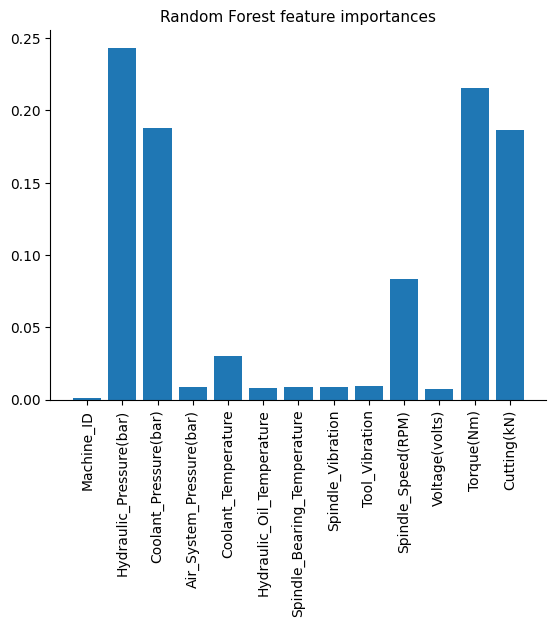

In [23]:
# Plot coefficients
plt.bar(X.columns, model.feature_importances_)
plt.title("Random Forest feature importances", fontsize=11)
plt.xticks(rotation=90)
sns.despine()
plt.show()

## Conclusion

Initially, I considered incorporating the time series data for predictive purposes. However, the exploratory analysis revealed no patterns associated with the dates, indicating that this was simply a feature-based classification problem.

While the Logistic Regression classifier performed reasonably well, the non-linearities in the dataset made the Random Forest classifier a more suitable model, yielding impressive results with minimal tuning.